<a href="https://colab.research.google.com/github/anaguilarar/Crop_DL/blob/main/Rice_seeds_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

To boost the process, please use gpu, habilitate the option in:
 runtime -> change runtime type -> hardware accelerator -> gpu . 

In [3]:
import os
if not os.path.exists("Crop_DL") and not os.getcwd().endswith("Crop_DL"):
    !git clone https://github.com/anaguilarar/Crop_DL.git
    print("Cloned")
    
else:
    print("crop_dl directory already exists")
if not os.getcwd().endswith("Crop_DL"):
  os.chdir("Crop_DL")

from crop_dl.seeds.rice_counting import RiceSeedsCounting
from crop_dl.models.dl_initilizer import DLInstanceModel
from crop_dl.models.utils import check_weigth_path, downloadzip

import matplotlib.pyplot as plt
import torch
import os

crop_dl directory already exists


### Configuration

Here the user defines the folder's name that contains the images that will be analyzed.
Likewise, the model will be updated with a pre-trained version. this version is stored in an amazon bucket


In [18]:
IMAGESPATH = "example_imagery/seeds"
WEIGHTSURL= "https://dlmodels-bucket.s3.ap-northeast-1.amazonaws.com/maskrcnn_rice_seeds.zip"
PREDICTION_CONFIDENCE = 0.65
WEIGHTSPATH = check_weigth_path(WEIGHTSURL, suffix="checkpoint", weights_path="model_weights")


['maskrcnn_rice_seeds_20230308-000041/checkpoint']


### Setting the model and datasets


In [19]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

seed_model = DLInstanceModel(WEIGHTSPATH,
                 device = device)

ricecounts = RiceSeedsCounting(
                 IMAGESPATH,
                 seed_model.model, 
                 imagessuffix = ".jpg",
                 device = device)

print("files available in folder: ",ricecounts.listfiles)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


weights loaded
files available in folder:  ['test3.jpg', 'test8.jpg', 'test2.jpg', 'test10.jpg', 'test9.jpg', 'test5.jpg', 'test.jpg', 'test11.jpg', 'test6.jpg', 'test4.jpg', 'test7.jpg']


### Detecting the rice seeds for an specific image

True

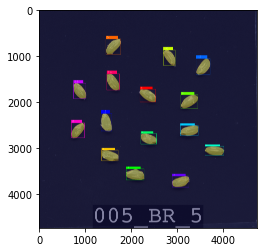

In [24]:
import cv2

img_number = 7
ricecounts.detect_rice(img_number, keepsize=True, segment_threshold = 170, threshold = PREDICTION_CONFIDENCE)
m = ricecounts.plot_prediction(only_image=True)
plt.imshow(m[:,:,[2,1,0]])


In [ ]:
## Run this cell if you want to export the above image
cv2.imwrite("pred_{}".format(ricecounts.listfiles[ricecounts.idimg]), m)

#### Extracting information for a single seed

{'fn': ['test11.jpg'], 'seed_id': [2], 'height': [388.9730067755345], 'width': [212.20037700249262], 'area': [65894.0]}


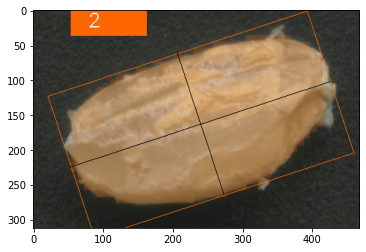

In [21]:
seed_number = 2
m = ricecounts.plot_individual_seed(seed_number)
print(ricecounts.calculate_oneseed_metrics(seed_number))
plt.imshow(m[:,:,[2,1,0]])

#### Extracting information for all seeds

In [9]:
filename = "{}_data.csv".format(
    ricecounts.listfiles[ricecounts.idimg][:ricecounts.listfiles[ricecounts.idimg].index(".jpg")])

df = ricecounts.one_image_seeds_summary()
df.to_csv(filename)
print(f"the data was saved in {filename}")
df


the data was saved in test11_data.csv


,fn,seed_id,height,width,area
0,test11.jpg,0,405.000000,192.000000,64777.0
0,test11.jpg,1,386.000000,219.000000,67565.0
0,test11.jpg,2,388.973007,212.200377,65894.0
0,test11.jpg,3,386.000000,239.000000,72024.0
0,test11.jpg,4,358.000000,229.000000,64776.0
0,test11.jpg,5,425.868524,203.039405,67046.0
0,test11.jpg,6,413.859880,210.535033,65190.0
0,test11.jpg,7,339.000000,229.000000,60562.0
0,test11.jpg,8,386.080303,197.989899,59693.0
0,test11.jpg,9,423.615392,216.448608,70404.0


#### Extracting the data for all the files that are inside the folder

In [16]:
filename = "all_data.csv"
df = ricecounts.all_image_seeds_summary(threshold = PREDICTION_CONFIDENCE)
df.to_csv(filename)
df

100%|██████████| 11/11 [00:04<00:00,  2.52it/s]


,fn,seed_id,height,width,area
0,test3.jpg,0,89.888820,37.735925,3023.0
0,test3.jpg,1,83.168504,38.897301,2788.0
0,test3.jpg,2,84.000000,41.000000,3038.0
0,test3.jpg,3,93.150416,40.311289,3191.0
0,test3.jpg,4,83.000000,43.000000,3036.0
...,...,...,...,...,...
0,test4.jpg,8,92.000000,26.000000,2350.0
0,test7.jpg,0,148.000000,67.000000,8892.0
0,test7.jpg,1,144.000000,122.000000,15605.0
0,test7.jpg,2,151.000000,66.000000,8724.0


100%|██████████| 11/11 [00:04<00:00,  2.56it/s]


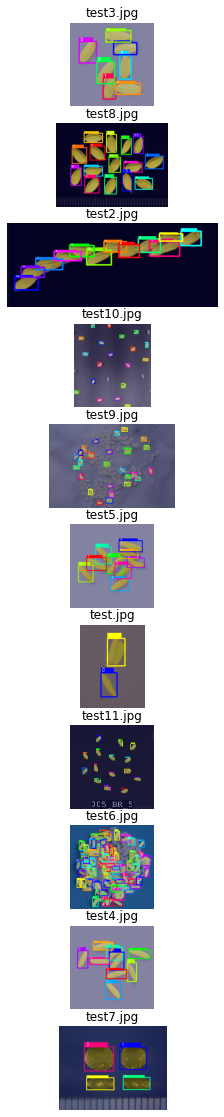

In [22]:
images = ricecounts.all_image_predictions(threshold = PREDICTION_CONFIDENCE)

f, ax = plt.subplots(nrows=len(images), ncols=1, figsize = (10,20))

for i in range(len(images)):
    ax[i].imshow(images[i])
    ax[i].set_axis_off()
    ax[i].set_title(ricecounts.listfiles[i])